In [1]:
import math
import pandas as pd
import numpy as np
import igraph
import itertools
import matplotlib.pyplot as plt
from notears import linear
from notears import utils
%matplotlib inline

tol = 0.00001

In [1]:
class dag():
    
    def __init__(self, m):
        '''
        m is a pandas DataFrame conaining an adjacency matrix
        '''
        self.m = m
        self.nodes = self.m.columns.values
        self.lags = np.array([n for n in self.nodes if '_1' in n])
        if not all(self.m.columns.values == self.m.index.values):
            raise ValueError('Invalid adjacency matrix (columns and rows are not the same)')
        self.directed = self.directed()

            
    def parents(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[self.m.loc[:,n] != 0, n].index.values
    
    
    def children(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[:,self.m.loc[n,:] != 0].columns.values
    
    
    def directed(self):
        '''
        return true if the graph is directed
        '''
        directed = True
        for n in self.nodes:
            if len(set(self.parents(n)).intersection(set(self.children(n)))) != 0:
                directed = False
        return directed
        
    
    def depth(self, n):
        '''
        n is a node in the graph
        return the length of the shortest path to a root node
        '''
        if not self.directed:
            raise ValueError('Cannot compute depth, graph is undirected')
        if len(self.parents(n)) == 0:
            return 0
        else:
            return 1 + min([self.depth(p) for p in self.parents(n)])
    
    
    def root_nodes(self):
        '''
        return the root nodes of the graph
        '''
        return np.array([n for n in self.nodes if len(self.parents(n)) == 0])
        
        
    def isolated_nodes(self):
        '''
        return the isolated nodes in the graph
        '''
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) == 0)])
    
    
    def connected_roots(self):
        '''
        return the root nodes of the graph that are not isolated
        '''
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) > 0)])
    
    
    def structure(self):
        '''
        return a skeleton copy of the adjacency matrix where 1 indicates an edge and 0 no edge
        '''
        M = self.m.copy()
        M[M != 0] = 1
        return M
    
    
    def shd(self, d):
        '''
        return the structural hamming distance of the graph relative to another dag d
        '''
        try:
            return utils.count_accuracy(d.structure().values, self.structure().values)['shd']
        except ValueError as e:
            # Graph is not directed
            return None
    
    
    def calculate_irf(self, x_0, T=250):
        '''
        return a data frame containing T periods of impulse responses of the dag to shocks x_0
        '''
        out = pd.DataFrame([x_0], columns=self.nodes)
        for t in range(T):
            d = 0
            new_row = pd.DataFrame([], columns=self.nodes)
            while True:
                layer = [n for n in self.nodes if self.depth(n) == d]
                if len(layer) == 0:
                    out = pd.concat([out, new_row], axis=0)
                    break
                for n in layer:
                    if n in self.lags:
                        new_row.loc[0,n] = out.iloc[-1,:][n.rstrip('_1')]
                    elif d == 0:
                        new_row.loc[0,n] = 0
                    else:
                        new_row.loc[0,n] = np.dot(self.m.loc[:,n], new_row.iloc[0,:].fillna(0))
                d += 1   
        out.loc[:,'t'] = range(T+1)
        out.set_index('t', inplace=True)
        out.drop(self.lags, axis=1, inplace=True)
        return out
    
    
    def plot_irf(self, irf, layout=None):
        '''
        return pyplot plot of irfs generated by dag.calculate_irf
        '''
        if layout is None:
            side = math.ceil(math.sqrt(len(irf.columns)))
            layout = (side, side)
        axes = irf.plot(subplots=True, layout=layout, color="black", legend=False)
        for ax, name in zip(axes.flatten(), [x for x in self.nodes if x not in self.lags]):
            ax.axhline(y=0, color="red")
            ax.set_title(name)
        return plt
    
    
    def plot_structure(self):
        '''
        return igraph graph of the graph's structure
        '''
        M = self.m.values
        g = igraph.Graph.Adjacency((M != 0.0).tolist())
        g.es['weight'] = M[M.nonzero()]
        g.vs['label'] = self.nodes
        g.vs['color'] = 'white'
        g.vs['size'] = 45
        return g

In [2]:
# Importing data
data = pd.read_csv('../data/rbc_100k.csv')
data = data.drop(list(['eps_z', 'eps_g']), axis=1)
data.columns = [col.replace(" ", "") for col in data.columns]
data = data.iloc[:,1:] # Remove index column

# Recenter data
data = data.apply(lambda x: x - x.mean())

# Introduce lags of all variables
shift_vars = data.columns.values
shift = data.loc[:,shift_vars].shift()
shift.columns = [str(col) + '_1' for col in shift.columns]
data = pd.concat([data, shift], axis=1)
data = data.iloc[1:,:]

data_array = data.values

NameError: name 'pd' is not defined

In [5]:
bl_children = np.where(np.isin(data.columns.values, shift.columns.values))[0]
bl_parents  = None
d = data_array.shape[1]
dag_bnds = [
        (0, 0)
        if i == j
        else (0, 0) 
        if bl_parents is not None and i in bl_parents
        else (0, 0) 
        if bl_children is not None and j in bl_children
        else (-1 + tol, 1 - tol) # Assume stationary solution
        for i in range(d)
        for j in range(d)
    ] 

In [12]:
# Define ground truth DAG
d = len(data.columns)
gt = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))), columns=data.columns, index=data.columns)
for j in ['z', 'g', 'k_1']:
    h = gt.columns[0:np.int(d/2)]
    gt.loc[j,h] = 1
    
gt.loc['z_1', 'z'] = 1
gt.loc['g_1', 'g'] = 1

gt.loc['k_1', 'k_1'] = 0
gt.loc['z', 'z'] = 0
gt.loc['g', 'g'] = 0

gt.loc['g', 'z'] = 0
gt.loc['z', 'g'] = 0
gt.loc['k_1', 'z'] = 0
gt.loc['k_1', 'g'] = 0
gt.loc['g', 'k_1'] = 0
gt.loc['g', 'k_1'] = 0
gt.loc['z', 'k_1'] = 0
gt.loc['z', 'k_1'] = 0

gt = dag(gt)

In [13]:
def grid_search():
    results = pd.DataFrame(columns=['SHD', 'root_nodes', 'directed', 'dag', 'params'])
    lambda1s = np.linspace(1e1, 1e-50, 10) 
    w_thresholds = np.linspace(0, 0.99, 10)
    loss_types = ['l2', 'logistic', 'poisson']
    bndss = [dag_bnds]
    params = [lambda1s, w_thresholds, loss_types, bndss]
    grid = list(itertools.product(*params))
    gridsize = len(grid)
    
    i = 1
    for p in grid:
        W_est = linear.notears_linear(data_array, 
                                      lambda1=p[0], 
                                      w_threshold=p[1],
                                      loss_type=p[2], 
                                      bnds=p[3],
                                      max_iter=1000, 
                                      h_tol=1e-8, 
                                      rho_max=1e+20)
        d = dag(pd.DataFrame(W_est, index=data.columns.values, columns=data.columns.values))
        shd = d.shd(gt)
        root_nodes = d.root_nodes()
        directed = d.directed

        results = results.append({
            'SHD': shd,
            'root_nodes': root_nodes,
            'directed': directed,
            'dag': d,
            'params': {
                'lambda1': p[0],
                'w_threshold': p[1],
                'loss_type': p[2],
                'bnds': p[3]
            }
         }, ignore_index=True)
        print('Completed iteration {} of {} ({}%)\n SHD: {}'.format(i, gridsize, np.round(i/gridsize*100, 2), shd))
        i += 1
        
        
    print('FINISHED')
    return results

In [14]:
results = grid_search()

Completed iteration 1 of 300 (0.33%)
 SHD: None
Completed iteration 2 of 300 (0.67%)
 SHD: None
Completed iteration 3 of 300 (1.0%)
 SHD: None
Completed iteration 4 of 300 (1.33%)
 SHD: 107
Completed iteration 5 of 300 (1.67%)
 SHD: 102
Completed iteration 6 of 300 (2.0%)
 SHD: 107
Completed iteration 7 of 300 (2.33%)
 SHD: 104
Completed iteration 8 of 300 (2.67%)
 SHD: 102
Completed iteration 9 of 300 (3.0%)
 SHD: 105
Completed iteration 10 of 300 (3.33%)
 SHD: 102
Completed iteration 11 of 300 (3.67%)
 SHD: 102
Completed iteration 12 of 300 (4.0%)
 SHD: 101
Completed iteration 13 of 300 (4.33%)
 SHD: 98
Completed iteration 14 of 300 (4.67%)
 SHD: 102
Completed iteration 15 of 300 (5.0%)
 SHD: 97
Completed iteration 16 of 300 (5.33%)
 SHD: 94
Completed iteration 17 of 300 (5.67%)
 SHD: 103
Completed iteration 18 of 300 (6.0%)
 SHD: 97
Completed iteration 19 of 300 (6.33%)
 SHD: 93
Completed iteration 20 of 300 (6.67%)
 SHD: 103
Completed iteration 21 of 300 (7.0%)
 SHD: 96
Completed i

Completed iteration 170 of 300 (56.67%)
 SHD: 101
Completed iteration 171 of 300 (57.0%)
 SHD: 98
Completed iteration 172 of 300 (57.33%)
 SHD: 95
Completed iteration 173 of 300 (57.67%)
 SHD: 101
Completed iteration 174 of 300 (58.0%)
 SHD: 97
Completed iteration 175 of 300 (58.33%)
 SHD: 95
Completed iteration 176 of 300 (58.67%)
 SHD: 100
Completed iteration 177 of 300 (59.0%)
 SHD: 93
Completed iteration 178 of 300 (59.33%)
 SHD: 97
Completed iteration 179 of 300 (59.67%)
 SHD: 101
Completed iteration 180 of 300 (60.0%)
 SHD: 91
Completed iteration 181 of 300 (60.33%)
 SHD: None
Completed iteration 182 of 300 (60.67%)
 SHD: None
Completed iteration 183 of 300 (61.0%)
 SHD: None
Completed iteration 184 of 300 (61.33%)
 SHD: 105
Completed iteration 185 of 300 (61.67%)
 SHD: 99
Completed iteration 186 of 300 (62.0%)
 SHD: 104
Completed iteration 187 of 300 (62.33%)
 SHD: 103
Completed iteration 188 of 300 (62.67%)
 SHD: 99
Completed iteration 189 of 300 (63.0%)
 SHD: 102
Completed ite

In [17]:
results = results[results['directed']].sort_values(by='SHD')

In [18]:
results['root_nodes'] = results['dag'].apply(lambda x: x.root_nodes())
results['nroots'] = results['root_nodes'].apply(lambda x: len(x))
results['connected_roots'] = results['dag'].apply(lambda x: x.connected_roots())
results['nconroots'] = results['connected_roots'].apply(lambda x: len(x))

AttributeError: 'int' object has no attribute 'nodes'

In [27]:
[x['lambda1'] for x in results['params']]

[1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1e-50,
 1.1111111111111107,
 2.2222222222222214,
 1.1111111111111107,
 3.333333333333333,
 6.666666666666666,
 8.88888888888889,
 5.555555555555555,
 1e-50,
 10.0,
 1e-50,
 1e-50,
 4.444444444444445,
 1e-50,
 1e-50,
 1e-50,
 7.777777777777778,
 10.0,
 1e-50,
 10.0,
 10.0,
 10.0,
 7.777777777777778,
 4.444444444444445,
 7.777777777777778,
 7.777777777777778,
 7.777777777777778,
 7.777777777777778,
 6.666666666666666,
 7.777777777777778,
 6.666666666666666,
 6.666666666666666,
 6.666666666666666,
 6.666666666666666,
 4.444444444444445,
 10.0,
 5.555555555555555,
 2.2222222222222214,
 2.2222222222222214,
 5.555555555555555,
 6.666666666666666,
 1.1111111111111107,
 7.777777777777778,
 2.2222222222222214,
 8.88888888888889,
 10.0,
 1.1111111111111107,
 8.88888888888889,
 3.333333333333333,
 5.555555555555555,
 5.555555555555555,
 5.555555555555555,
 5.55555555555

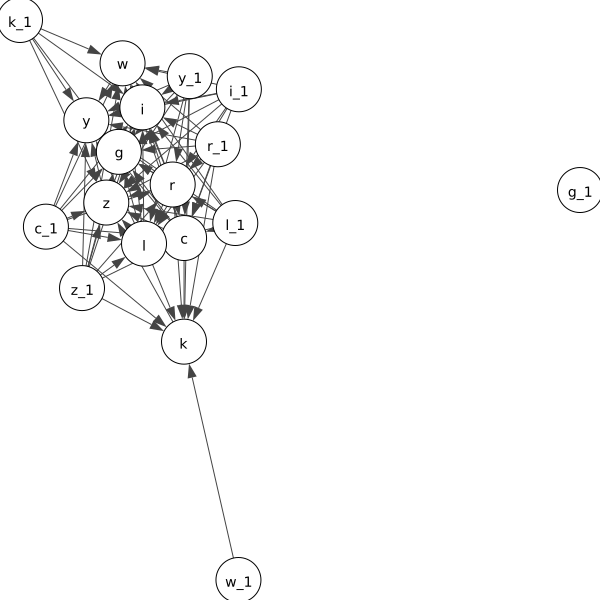

In [31]:
d = results.iloc[20,:]['dag']
g = d.plot_structure()
igraph.plot(g)

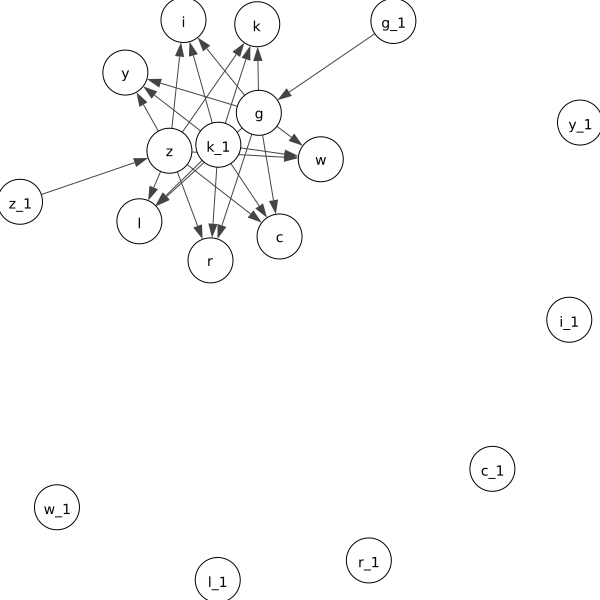

In [34]:
g = gt.plot_structure()
igraph.plot(g)

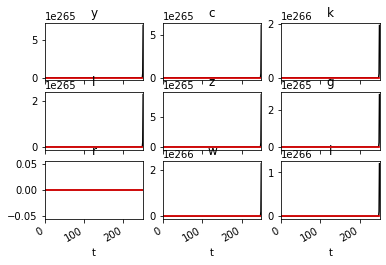

In [17]:
x_0 = np.array([0.0 for i in range(len(data.columns))])
x_0[4] = 0.66
irf = d.calculate_irf(x_0)
plt = d.plot_irf(irf)
plt.show()

In [ ]:
bl_children = np.where(np.isin(data.columns.values, shift.columns.values))[0]
bl_parents  = None # np.where(~np.isin(data.columns.values, shift.columns.values))[0]
d = data_array.shape[1]
# DAG
bnds = [
        (0, 0)
        if i == j
        else (0, 0) 
        if bl_parents is not None and i in bl_parents
        else (0, 0) 
        if bl_children is not None and j in bl_children
        else (-1 + tol, 1 - tol) # Assume stationary solution
        for i in range(d)
        for j in range(d)
    ] 

In [110]:
W_est = linear.notears_linear(data_array, 
                              lambda1=1e-30, 
                              w_threshold=0.5,
                              loss_type='logistic', 
                              max_iter=10000, 
                              h_tol=1e-10, 
                              rho_max=1e+25, 
                              bnds=bnds)
adj_df = pd.DataFrame(W_est, index=data.columns.values, columns=data.columns.values)

In [ ]:
d = dag(adj_df)

In [38]:
root_nodes = adj_df.columns.values[~adj_df.any()]
print(root_nodes)
print(np.count_nonzero(adj_df))

['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
27
